# LA Unpermitted-Housing Violations Parcels (2017+) — Exploratory Data Analysis

This notebook explores `udu_parcels.csv`, a **parcel-year** dataset of Los Angeles parcels associated with **unpermitted-housing violations (2017+)**.

Key goals:
- Understand structure (repeated assessor records across years).
- Summarize building/use characteristics.
- Create a **pre-2017 baseline** view (default: 2016) for descriptive analysis and later predictive feature engineering.
- Explore temporal changes in assessor attributes that may proxy unpermitted changes.

> Note: This dataset contains **only violators**. To study predictors in the broader building stock, you will need a comparison/control sample.


In [1]:
import os

os.chdir('../..')
!pwd

/Users/adamswietek/Documents/PostDoc/HiddenHousing


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

CSV_PATH = "data/udu_parcels.csv"  # adjust if needed


In [3]:
df = pd.read_csv(CSV_PATH)

# Drop index-like column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df.head()

,ZIPcode,TaxRateArea_CITY,AIN,RollYear,TaxRateArea,AssessorID,PropertyLocation,PropertyType,PropertyUseCode,GeneralUseType,SpecificUseType,SpecificUseDetail1,SpecificUseDetail2,totBuildingDataLines,YearBuilt,EffectiveYearBuilt,SQFTmain,Bedrooms,Bathrooms,Units,RecordingDate,LandValue,LandBaseYear,ImprovementValue,ImpBaseYear,TotalLandImpValue,HomeownersExemption,RealEstateExemption,FixtureValue,FixtureExemption,PersonalPropertyValue,PersonalPropertyExemption,isTaxableParcel?,TotalValue,TotalExemption,netTaxableValue,SpecialParcelClassification,AdministrativeRegion,Cluster,ParcelBoundaryDescription,HouseNo,HouseFraction,StreetDirection,StreetName,UnitNo,City,ZIPcode5,rowID,CENTER_LAT,CENTER_LON,Location 1
0,90045-3703,LOS ANGELES,4122006007,2019,68,4122-006-007,6400 W 86TH PL LOS ANGELES CA 90045,R-I,0300,Residential,Three Units (Any Combination),4 Stories or Less,NaN,2,1944,1947,2012,4,3,3,20061229,469806.0,2007,126802.0,2007,596608.0,0.0,0.0,0.0,0.0,0.0,0.0,Y,596608.0,0.0,596608.0,NaN,09,9409,TRACT NO 12O76 LOT 22,6400,NaN,W,86TH PL,NaN,LOS ANGELES CA,90045.0,20194122006007,33.959134,-118.398980,"(33.9591337, -118.39897967)"
1,90066-3945,LOS ANGELES,4214017026,2019,67,4214-017-026,11820 VENICE BLVD LOS ANGELES CA 90066,R-I,0500,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,NaN,1,1964,1964,6663,7,13,13,20120831,900785.0,2012,562990.0,2012,1463775.0,0.0,0.0,0.0,0.0,1300.0,0.0,Y,1465075.0,0.0,1465075.0,NaN,09,9407,TRACT # 3842 LOT 23 BLK D,11820,NaN,NaN,VENICE BLVD,NaN,LOS ANGELES CA,90066.0,20194214017026,34.007649,-118.425537,"(34.00764905, -118.42553655)"
2,90292-5162,LOS ANGELES,4225001042,2019,67,4225-001-042,"10 ANCHORAGE ST, NO 4 LOS ANGELES CA 90292",R-I,0500,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,NaN,1,1970,1970,5068,10,9,6,20130612,503748.0,1987,351789.0,1987,855537.0,0.0,0.0,0.0,0.0,0.0,0.0,Y,855537.0,0.0,855537.0,NaN,07,7406,SHORT LINE BEACH SUB # 4 LOT 23 BLK 26,10,NaN,NaN,ANCHORAGE ST,NO 4,LOS ANGELES CA,90292.0,20194225001042,33.978587,-118.465907,"(33.97858725, -118.46590688)"
3,90292-5918,LOS ANGELES,4225010028,2019,67,4225-010-028,"3900 PACIFIC AVE, APT 0001 LOS ANGELES CA 90292",R-I,0300,Residential,Three Units (Any Combination),4 Stories or Less,NaN,1,1969,1969,4224,8,7,3,20170403,1125982.0,2012,368756.0,2012,1494738.0,0.0,0.0,0.0,0.0,500.0,0.0,Y,1495238.0,0.0,1495238.0,NaN,07,7406,SILVER STRAND (EX OF ST) LOT 14 BLK 5,3900,NaN,NaN,PACIFIC AVE,APT 0001,LOS ANGELES CA,90292.0,20194225010028,33.975433,-118.462040,"(33.97543282, -118.46204016)"
4,90292-5790,LOS ANGELES,4225005040,2019,67,4225-005-040,33 DRIFTWOOD ST LOS ANGELES CA 90292,R-I,0500,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,NaN,1,1970,1970,16763,0,20,19,20000630,295742.0,1977,591505.0,1977,887247.0,0.0,0.0,0.0,0.0,0.0,0.0,Y,887247.0,0.0,887247.0,NaN,07,7406,LOTS 10 AND 11 BLK 28 SHORT LINE BEACH SUB NO ...,33,NaN,NaN,DRIFTWOOD ST,NaN,LOS ANGELES CA,90292.0,20194225005040,33.977644,-118.464272,"(33.97764424, -118.46427167)"


In [4]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("\nColumn names:")
print(df.columns.tolist())

# Basic dtypes + missingness
missing = (df.isna().mean().sort_values(ascending=False) * 100).to_frame("pct_missing")
dtypes = df.dtypes.to_frame("dtype")
summary = dtypes.join(missing)
summary.head(20)

Rows: 2921
Columns: 51

Column names:
['ZIPcode', 'TaxRateArea_CITY', 'AIN', 'RollYear', 'TaxRateArea', 'AssessorID', 'PropertyLocation', 'PropertyType', 'PropertyUseCode', 'GeneralUseType', 'SpecificUseType', 'SpecificUseDetail1', 'SpecificUseDetail2', 'totBuildingDataLines', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain', 'Bedrooms', 'Bathrooms', 'Units', 'RecordingDate', 'LandValue', 'LandBaseYear', 'ImprovementValue', 'ImpBaseYear', 'TotalLandImpValue', 'HomeownersExemption', 'RealEstateExemption', 'FixtureValue', 'FixtureExemption', 'PersonalPropertyValue', 'PersonalPropertyExemption', 'isTaxableParcel?', 'TotalValue', 'TotalExemption', 'netTaxableValue', 'SpecialParcelClassification', 'AdministrativeRegion', 'Cluster', 'ParcelBoundaryDescription', 'HouseNo', 'HouseFraction', 'StreetDirection', 'StreetName', 'UnitNo', 'City', 'ZIPcode5', 'rowID', 'CENTER_LAT', 'CENTER_LON', 'Location 1']


,dtype,pct_missing
ZIPcode,object,0.102705
TaxRateArea_CITY,object,0.000000
AIN,int64,0.000000
RollYear,int64,0.000000
TaxRateArea,int64,0.000000
AssessorID,object,0.000000
PropertyLocation,object,0.513523
PropertyType,object,0.102705
PropertyUseCode,object,0.000000
GeneralUseType,object,0.000000


In [5]:
# Panel structure
n_parcels = df["AIN"].nunique()
years = np.sort(df["RollYear"].unique())

print("Unique parcels (AIN):", n_parcels)
print("Roll years:", years.min(), "to", years.max(), f"({len(years)} years)")

# How many years per parcel?
years_per_parcel = df.groupby("AIN")["RollYear"].nunique().describe()
years_per_parcel

Unique parcels (AIN): 184
Roll years: 2006 to 2021 (16 years)


count    184.000000
mean      15.875000
std        1.116506
min        2.000000
25%       16.000000
50%       16.000000
75%       16.000000
max       16.000000
Name: RollYear, dtype: float64

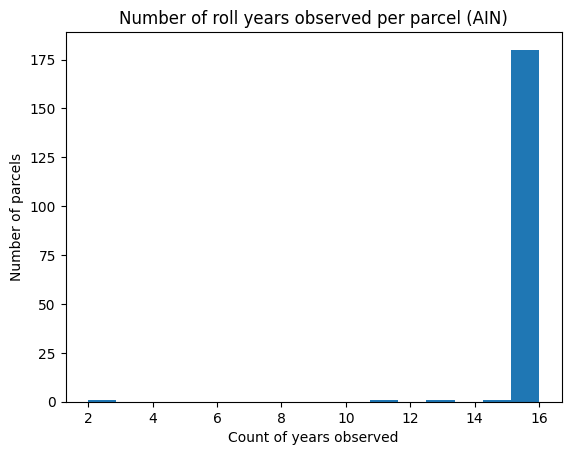

RollYear
2       1
11      1
13      1
15      1
16    180
Name: count, dtype: int64

In [6]:
ax = df.groupby("AIN")["RollYear"].nunique().plot(kind="hist", bins=16)
plt.title("Number of roll years observed per parcel (AIN)")
plt.xlabel("Count of years observed")
plt.ylabel("Number of parcels")
plt.show()

df.groupby("AIN")["RollYear"].nunique().value_counts().sort_index()

## Create a pre-2017 baseline (default: 2016)

For descriptive analysis and later prediction work, we want features that are measured **before** violations (2017+).  
We take the 2016 row when available; otherwise we take the latest year < 2017 for that parcel.


In [7]:
BASELINE_YEAR = 2016

pre = df[df["RollYear"] < 2017].copy()

# Prefer 2016; if missing, use latest pre-2017 year per parcel
pre["is_baseline_year"] = (pre["RollYear"] == BASELINE_YEAR).astype(int)
pre_sorted = pre.sort_values(["AIN", "is_baseline_year", "RollYear"], ascending=[True, False, False])

baseline = pre_sorted.groupby("AIN", as_index=False).head(1).copy()

print("Parcels with baseline rows:", baseline["AIN"].nunique(), "of", df["AIN"].nunique())
print("Baseline year distribution:")
print(baseline["RollYear"].value_counts().sort_index())

baseline.head()

Parcels with baseline rows: 183 of 184
Baseline year distribution:
RollYear
2016    183
Name: count, dtype: int64


,ZIPcode,TaxRateArea_CITY,AIN,RollYear,TaxRateArea,AssessorID,PropertyLocation,PropertyType,PropertyUseCode,GeneralUseType,SpecificUseType,SpecificUseDetail1,SpecificUseDetail2,totBuildingDataLines,YearBuilt,EffectiveYearBuilt,SQFTmain,Bedrooms,Bathrooms,Units,RecordingDate,LandValue,LandBaseYear,ImprovementValue,ImpBaseYear,TotalLandImpValue,HomeownersExemption,RealEstateExemption,FixtureValue,FixtureExemption,PersonalPropertyValue,PersonalPropertyExemption,isTaxableParcel?,TotalValue,TotalExemption,netTaxableValue,SpecialParcelClassification,AdministrativeRegion,Cluster,ParcelBoundaryDescription,HouseNo,HouseFraction,StreetDirection,StreetName,UnitNo,City,ZIPcode5,rowID,CENTER_LAT,CENTER_LON,Location 1,is_baseline_year
1726,91335-2863,LOS ANGELES,2102021039,2016,8852,2102-021-039,7722 RESEDA BLVD LOS ANGELES CA 91335,R-I,0501,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,Pool,1,1978,1978,92122,99,99,138,20130531,4473014.0,2013,10600003.0,2013,15073017.0,0.0,0.0,0.0,0.0,9050.0,0.0,Y,15082067.0,0.0,15082067.0,,28,28403,*TR=32907 LOT 1,7722,,,RESEDA BLVD,,LOS ANGELES CA,91335.0,20162102021039,34.210883,-118.535431,"RESEDA BLVD\n(34.2108834, -118.53543116)",1
1727,91316-2144,LOS ANGELES,2162007069,2016,37,2162-007-069,5207 ZELZAH AVE LOS ANGELES CA 91316,R-I,0501,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,Pool,1,1977,1977,18061,30,30,15,20131213,561568.0,2002,1310332.0,2002,1871900.0,0.0,0.0,0.0,0.0,3750.0,0.0,Y,1875650.0,0.0,1875650.0,,02,2412,*TR=6076* S 116 FT OF E 134 FT OF LOT 13,5207,,,ZELZAH AVE,,LOS ANGELES CA,91316.0,20162162007069,34.165611,-118.522341,"ZELZAH AVE\n(34.16561115, -118.52234143)",1
1728,91402-4536,LOS ANGELES,2209005026,2016,16,2209-005-026,15126 ROSCOE BLVD LOS ANGELES CA 91402,R-I,0500,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,,1,1987,1987,19222,40,40,21,20061113,1659603.0,2007,2374913.0,2007,4034516.0,0.0,0.0,0.0,0.0,11300.0,0.0,Y,4045816.0,0.0,4045816.0,,03,3404,TR=16357 LOT 68 AND EX OF STS LOT 69,15126,,,ROSCOE BLVD,,LOS ANGELES CA,91402.0,20162209005026,34.221118,-118.462122,"ROSCOE BLVD\n(34.22111818, -118.46212225)",1
1729,91405-3566,LOS ANGELES,2219016039,2016,13,2219-016-039,6944 KESTER AVE LOS ANGELES CA 91405,R-I,0500,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,,1,1977,1977,11313,13,23,21,19850621,397908.0,1985,928481.0,1985,1326389.0,0.0,0.0,0.0,0.0,11000.0,0.0,Y,1337389.0,0.0,1337389.0,,03,3407,TRACT NO 28090 LOT 2,6944,,,KESTER AVE,,LOS ANGELES CA,91405.0,20162219016039,34.197000,-118.457020,"KESTER AVE\n(34.19699951, -118.45702032)",1
1730,91406-7220,LOS ANGELES,2224005030,2016,16,2224-005-030,15705 VOSE ST LOS ANGELES CA 91406,R-I,0500,Residential,Five or More Units or Apartments (Any Combinat...,4 Stories or Less,,1,2003,2003,9710,16,16,12,20031202,307034.0,2002,1260168.0,2003,1567202.0,0.0,0.0,0.0,0.0,6000.0,0.0,Y,1573202.0,0.0,1573202.0,,2,2412,TR=12438 E 120 FT MEASURED ON N LINE EX OF ST ...,15705,,,VOSE ST,,LOS ANGELES CA,91406.0,20162224005030,34.198666,-118.475265,"VOSE ST\n(34.19866595, -118.47526502)",1


In [8]:
# Core distributions (baseline)
def simple_value_counts(s, n=15):
    return s.value_counts(dropna=False).head(n)

print("GeneralUseType (baseline):")
display(simple_value_counts(baseline["GeneralUseType"], 20))

print("\nSpecificUseType (baseline):")
display(simple_value_counts(baseline["SpecificUseType"], 20))

print("\nSpecificUseDetail1 (baseline):")
display(simple_value_counts(baseline["SpecificUseDetail1"], 20))

# Year built and age in baseline year
baseline["BuildingAge"] = baseline["RollYear"] - baseline["YearBuilt"]

baseline[["YearBuilt", "BuildingAge"]].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

GeneralUseType (baseline):


GeneralUseType
Residential    179
Commercial       4
Name: count, dtype: int64


SpecificUseType (baseline):


SpecificUseType
Five or More Units or Apartments (Any Combination)    80
Double, Duplex, or Two Units                          39
Three Units (Any Combination)                         36
Four Units  (Any Combination)                         21
Single Family Residence                                3
Store Combination                                      3
Professional Building                                  1
Name: count, dtype: int64


SpecificUseDetail1 (baseline):


SpecificUseDetail1
4 Stories or Less                    176
                                       3
Store and Residential Combination      3
Medical Dental Building                1
Name: count, dtype: int64

,YearBuilt,BuildingAge
count,183.000000,183.000000
mean,1936.448087,79.551913
std,147.351513,147.351513
min,0.000000,3.000000
10%,1908.000000,28.000000
25%,1923.000000,42.000000
50%,1944.000000,72.000000
75%,1974.000000,93.000000
90%,1988.000000,108.000000
max,2013.000000,2016.000000


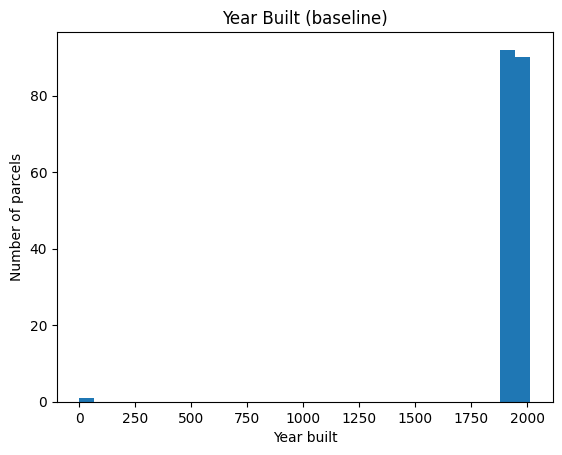

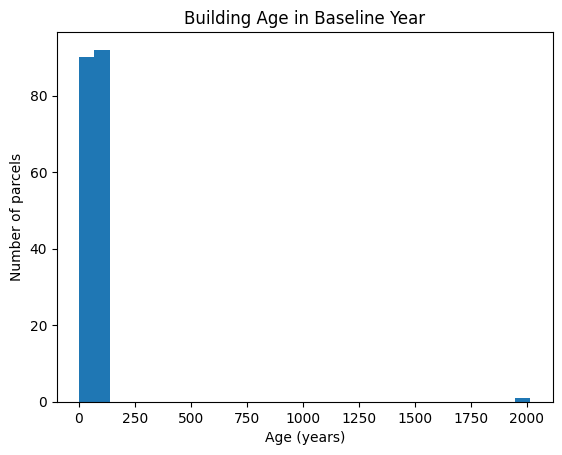

In [9]:
# Plots: YearBuilt and age
baseline["YearBuilt"].plot(kind="hist", bins=30)
plt.title("Year Built (baseline)")
plt.xlabel("Year built")
plt.ylabel("Number of parcels")
plt.show()

baseline["BuildingAge"].plot(kind="hist", bins=30)
plt.title("Building Age in Baseline Year")
plt.xlabel("Age (years)")
plt.ylabel("Number of parcels")
plt.show()

In [11]:
# Intensity proxies (baseline)
cols = [c for c in ["Units", "SQFTmain", "Bedrooms", "Bathrooms"] if c in baseline.columns]
display(baseline[cols].describe(percentiles=[0.1,0.25,0.5,0.75,0.9]))

# Derived: sqft per unit (avoid division by zero)
baseline["sqft_per_unit"] = baseline["SQFTmain"] / baseline["Units"].replace({0: np.nan})

baseline["sqft_per_unit"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

,Units,SQFTmain,Bedrooms,Bathrooms
count,183.000000,183.000000,183.000000,183.000000
mean,9.027322,8111.857923,12.278689,12.054645
std,14.161716,11552.907704,16.344638,17.121007
min,0.000000,0.000000,0.000000,0.000000
10%,2.000000,1930.000000,2.000000,2.000000
25%,3.000000,2612.000000,4.000000,3.000000
50%,4.000000,3783.000000,6.000000,5.000000
75%,9.000000,8096.500000,13.000000,12.500000
90%,21.000000,18162.600000,30.000000,30.000000
max,138.000000,92122.000000,99.000000,99.000000


count     182.000000
mean     1015.740885
std       431.299991
min       316.285714
10%       645.053333
25%       781.354167
50%       911.357143
75%      1146.400000
90%      1424.510345
max      3783.000000
Name: sqft_per_unit, dtype: float64

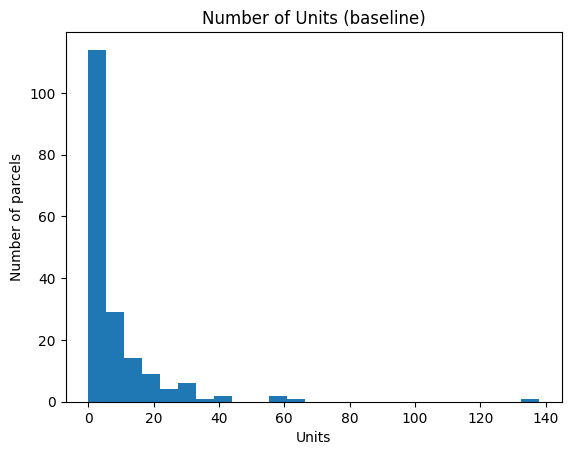

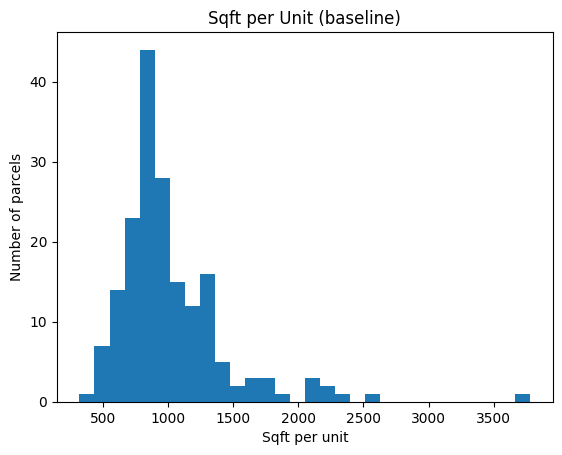

In [12]:
# Plots: units and sqft per unit
if "Units" in baseline.columns:
    baseline["Units"].plot(kind="hist", bins=25)
    plt.title("Number of Units (baseline)")
    plt.xlabel("Units")
    plt.ylabel("Number of parcels")
    plt.show()

baseline["sqft_per_unit"].dropna().plot(kind="hist", bins=30)
plt.title("Sqft per Unit (baseline)")
plt.xlabel("Sqft per unit")
plt.ylabel("Number of parcels")
plt.show()

In [13]:
# Assessed value structure (baseline)
value_cols = [c for c in ["LandValue", "ImprovementValue", "TotalValue", "netTaxableValue"] if c in baseline.columns]
display(baseline[value_cols].describe(percentiles=[0.1,0.25,0.5,0.75,0.9]))

baseline["impr_to_land"] = baseline["ImprovementValue"] / baseline["LandValue"].replace({0: np.nan})

baseline["impr_to_land"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

,LandValue,ImprovementValue,TotalValue,netTaxableValue
count,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02
mean,6.128645e+05,6.088639e+05,1.223721e+06,1.223071e+06
std,1.420436e+06,1.170859e+06,2.297773e+06,2.297969e+06
min,1.219700e+04,0.000000e+00,3.226200e+04,2.814900e+04
10%,9.368240e+04,8.675080e+04,2.075134e+05,2.075134e+05
25%,1.743825e+05,1.336880e+05,3.545645e+05,3.525445e+05
50%,2.885990e+05,2.889520e+05,5.796350e+05,5.796350e+05
75%,5.955060e+05,5.944365e+05,1.136856e+06,1.136856e+06
90%,1.183270e+06,1.291456e+06,2.638170e+06,2.638170e+06
max,1.760409e+07,1.060000e+07,2.228140e+07,2.228140e+07


count    183.000000
mean       1.250542
std        1.209696
min        0.000000
10%        0.399989
25%        0.566587
50%        0.844824
75%        1.500064
90%        2.333428
max        9.973701
Name: impr_to_land, dtype: float64

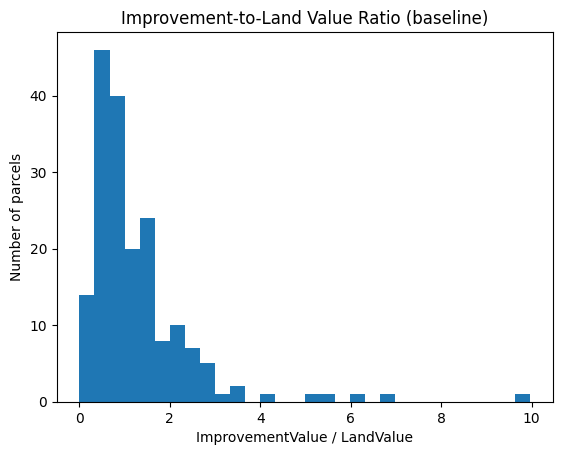

In [14]:
baseline["impr_to_land"].dropna().plot(kind="hist", bins=30)
plt.title("Improvement-to-Land Value Ratio (baseline)")
plt.xlabel("ImprovementValue / LandValue")
plt.ylabel("Number of parcels")
plt.show()

ZIPcode5
90011.0    10
90292.0     9
90003.0     8
90037.0     7
90731.0     6
90035.0     6
90034.0     6
90033.0     5
90007.0     5
90038.0     5
90026.0     4
90019.0     4
90029.0     4
90027.0     4
91401.0     4
Name: count, dtype: int64

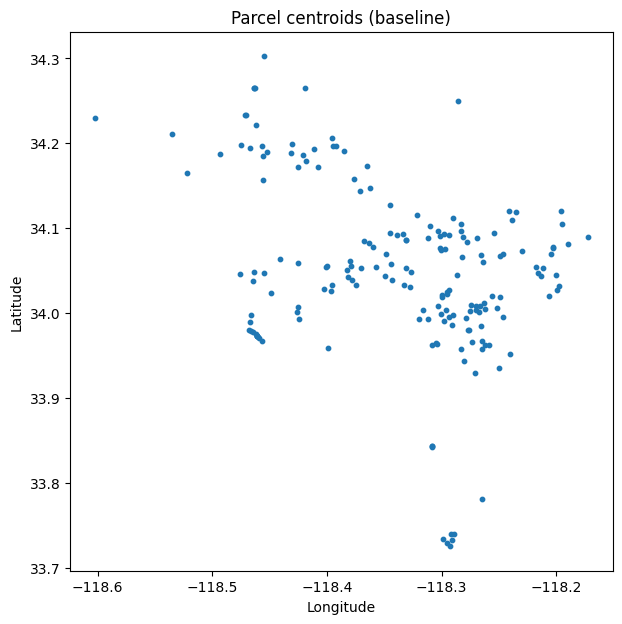

In [15]:
# Quick geography summaries (baseline)
# ZIP5
if "ZIPcode5" in baseline.columns:
    zip_counts = baseline["ZIPcode5"].value_counts().head(15)
    display(zip_counts)

# Scatter map using center lat/lon (if present)
if "CENTER_LAT" in baseline.columns and "CENTER_LON" in baseline.columns:
    plt.figure(figsize=(7,7))
    plt.scatter(baseline["CENTER_LON"], baseline["CENTER_LAT"], s=10)
    plt.title("Parcel centroids (baseline)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

## Temporal change signals (pre-2017)

We compute whether key physical attributes ever change across pre-2017 roll years for each parcel:
- Units, bedrooms, bathrooms, main sqft, effective year built


In [16]:
pre = df[df["RollYear"] < 2017].copy()

change_cols = [c for c in ["NoOfUnits", "Bedrooms", "Bathrooms", "SQFTmain", "EffectiveYearBuilt"] if c in pre.columns]

def any_change(group, col):
    s = group[col].dropna()
    if s.empty:
        return np.nan
    return int(s.nunique() > 1)

change_flags = pre.groupby("AIN").apply(lambda g: pd.Series({f"{c}_changed": any_change(g, c) for c in change_cols}))
change_flags = change_flags.reset_index()

change_summary = change_flags.drop(columns=["AIN"]).mean(numeric_only=True).sort_values(ascending=False).to_frame("share_with_change")
change_summary

/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_41307/2611566803.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  change_flags = pre.groupby("AIN").apply(lambda g: pd.Series({f"{c}_changed": any_change(g, c) for c in change_cols}))


,share_with_change
Bedrooms_changed,0.098361
Bathrooms_changed,0.087432
EffectiveYearBuilt_changed,0.081967
SQFTmain_changed,0.071038


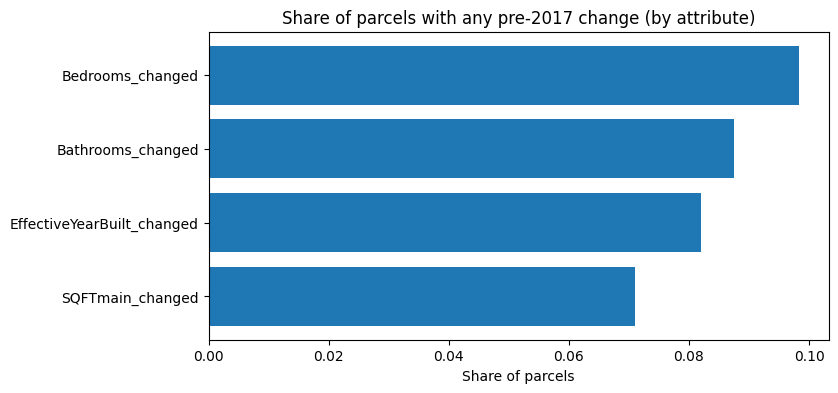

In [17]:
# Bar chart of share with any pre-2017 change
s = change_summary["share_with_change"].sort_values(ascending=True)
plt.figure(figsize=(8,4))
plt.barh(s.index, s.values)
plt.title("Share of parcels with any pre-2017 change (by attribute)")
plt.xlabel("Share of parcels")
plt.ylabel("")
plt.show()

## Next steps (for prediction beyond this sample)

Because you have only violators, to estimate *predictors* you need a control group:
- Sample parcels without these violations (matched on geography/use/type, etc.)
- Build features using only pre-2017 history (e.g., 2016 snapshot + multi-year trends)

High-value external joins for unpermitted-housing prediction:
- LADBS permits & inspections (detect “changes without permits”)
- 311 complaints / LAHD code enforcement exposure (detection bias)
- Zoning/allowable intensity (recorded vs allowed units/FAR)
- Neighborhood demand and overcrowding (ACS)
